In [1]:
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, vectorize, float64, int64
import seaborn as sns
import pandas as pd
import math 

In [267]:
def p_dk_h1k(data, alpha):
    '''
    To calculate the probability under hypothesis 1
    
    Input：
    data is an array
    alpha is the learning hyperparamter mentioned in the essay
    '''
    
    N=data.shape[0]
    k=data.shape[1]
    if(k==1):
        alpha=[0.9,0.1,0.5]
    prod = [special.loggamma(np.sum(data[i, :])+1)-np.sum(special.loggamma(data[i, :]+1)) for i in range(N)]
    multiplier1 = np.sum(prod)
    
    prod2 = [special.loggamma(alpha[j]+np.sum(data[:, j]))-special.loggamma(alpha[j]) for j in range(k)]
    multiplier2 = np.sum(prod2)
    
    logprob = multiplier1 + multiplier2 + special.loggamma(np.sum(alpha))-special.loggamma(np.sum(data) + np.sum(alpha))
    prob = np.real(np.exp(logprob))
    
    return prob

In [268]:
class mynode():
    '''
    Class of node
    
    A node have:
      self.l: a left child
      self.r: a right child
      self.data: the data
      self.cluster: which cluster it belongs to
      self.n: number of nodes of the subtree of the node
      self.d: d value
      self.pi: pi value
      self.index: index of the node
      self.parent: index of the parent
    '''
    def __init__(self, left, right, data, cluster, alpha, index = None, parent = None):
        self.l = left
        self.r = right
        self.data = data
        self.cluster = cluster
            
        if(left == None):
            self.n = 1
            self.d = alpha
        else:
            self.n = left.n + right.n
            self.d = alpha*special.gamma(self.n) + left.d*right.d
                
        self.pi = alpha*special.gamma(self.n)/self.d
        self.index = index
        self.parent = parent

In [269]:
def pik(mynode, alpha):
    '''
     To calculate the pi_k value of the node
    
    Input：
      node
      alpha
    '''
    
    if mynode.l == None:
        dk = alpha
    else:
        dk = alpha*special.gamma(mynode.n) + mynode.l.d*mynode.r.d
    
    mynode.d = dk
    pi_k = alpha*special.gamma(mynode.n)/dk
    mynode.pi = pi_k
    
    return pi_k

In [270]:
def p_dk_tk(mynode, alpha=0.5):
    '''
    To calculate the P(D_k|T_k) value of the node
    
    Input：
      node
      alpha
    '''
    p = p_dk_h1k(mynode.data, np.repeat(alpha, mynode.data.shape[1]))
    pi = pik(mynode, alpha)
    if mynode.l == None:
        return  pi * p
    else:
        return  pi * p + (1-pi) * p_dk_tk(mynode.l, alpha) * p_dk_tk(mynode.r, alpha)

In [271]:
@jit 
def find_max_rk(mynode_list, alpha, dim):
    '''
    To find the pair i and j with the largest r_k value
    
    Input:
      nodelist
      alpha
      dimension of the data
      
    Return:
      the index of the pair: i_max, j_max
      the maximum r_k: rk_max
    '''
    
    rk_max = -10000
    i_max = 0
    j_max = 1
    
    # find the pair i and j with the highest probability of the merged hypothesis
    for i in range(len(mynode_list)):
        for j in range(i+1, len(mynode_list)):
            
            # concatenate the data of i and j
            newdata = np.concatenate((mynode_list[i].data, mynode_list[j].data), axis = 0)
                
            # creat a new mynode with i and j as its children
            mynode_new = mynode(mynode_list[i], mynode_list[j], newdata,
                                min(mynode_list[i].cluster,mynode_list[j].cluster), alpha)
            
            # calculate the r_k value
            rk = pik(mynode_new, alpha) * p_dk_h1k(mynode_new.data, np.repeat(alpha, dim)) / p_dk_tk(mynode_new, alpha)
            
            # record the largest r_k
            if (rk>rk_max):
                rk_max = rk
                i_max = i
                j_max = j
                
    return i_max, j_max, rk_max

In [272]:
def set_cluster(root,clusternum):
    '''
    Set the cluster number of all nodes in the subtree to clusternum
    '''
    queue = []

    queue.append(root)
    while queue:
        newNode = queue.pop(0)
        newNode.cluster = clusternum
        
        if newNode.l != None:
            queue.append(newNode.l)
        if newNode.r != None:
            queue.append(newNode.r)

    return

In [273]:
def bhc(data, alpha = 0.5, r_thres = 0.91):
    '''
    Bayesian Hierarchical Clustering
    
    Input：
      data 
      alpha
      threshold of r_k
    
    The tree can be cut at points where r_k<r_thres
    
    The function will return tree[0], assignments
      tree[0]: The root of the tree
      assignments: The cluster numbers of each merge
    '''
    
    tree = []
        
    num = data.shape[0]
    # initialize
    for i in range(num):
        tree.append(mynode(None, None, np.array([data[i,:]]), i, alpha, i, None))
        
    # number of clusters
    c = data.shape[0]
    
    # list for recording the cluster number
    assignment = [i for i in range(num)]
    assignments = [list(assignment)]
    
    while (c>1):        
        
        # determine which pair to merge (pair i,j with the largest r_k)
        tree_i_max, tree_j_max, tree_rk_max = find_max_rk(tree, alpha, data.shape[1])
        
        # the smaller cluster number
        tree_clusternum = min(tree[tree_i_max].cluster,tree[tree_j_max].cluster)
        # the larger cluster number
        max_clusternum = max(tree[tree_i_max].cluster,tree[tree_j_max].cluster)
        
        # set cluster numbers to the smaller one
        set_cluster(tree[tree_i_max],tree_clusternum)
        set_cluster(tree[tree_j_max],tree_clusternum)
        
        # creat a newnode with i,j as children
        tree_mynode_new_max = mynode(tree[tree_i_max], tree[tree_j_max], np.concatenate((tree[tree_i_max].data, tree[tree_j_max].data), axis = 0), 
                                tree_clusternum, alpha, index = num+data.shape[0]-c)
        
        # set the parent of i,j
        tree[tree_i_max].parent = tree_mynode_new_max.index
        tree[tree_j_max].parent = tree_mynode_new_max.index
        
        # construct the tree from leaves to the roots
        tree =  tree[:tree_i_max] + tree[(tree_i_max+1):tree_j_max] + tree[(tree_j_max+1):]
        tree = [tree_mynode_new_max] + tree
        
        c = c - 1
        
        # set the cluster number, record the cluster numbers of each merge
        for i, k in enumerate(assignment):
            if k == max_clusternum:
                assignment[i] = tree_clusternum
        assignments.append(list(assignment))
            
    return tree[0], assignments

In [274]:
def draw_dendrogram(root):
    '''
    Manually draw a dendrogram of the tree from root
    '''
    
    from anytree import Node, RenderTree
    
    # a queue to go through all the nodes in the subtree
    queue = []

    queue.append(root)
    while queue:
        newNode = queue.pop(0)
        
        # name the node as "D" + index
        ind = "D"+str(newNode.index)
        par = "D"+str(newNode.parent)
        if(newNode.parent == None):
            exec(ind + " = Node(\"" + ind + "\")")
        else:
            exec(ind + " = Node(\"" + ind + "\", parent=" + par + ")")
                        
        if newNode.l != None:
            queue.append(newNode.l)
        if newNode.r != None:
            queue.append(newNode.r)
    
    # draw the dendrogram
    exec("print(RenderTree(" + "D"+str(root.index) + "))")
    
    return

- Simulated Data

In [259]:
d1 = np.random.dirichlet((20, 1), 2)
d2 = np.random.dirichlet((1, 100), 2)
d3 = np.random.dirichlet((100, 100), 2)
sdata = np.concatenate((d1,d2,d3),axis=0).reshape(-1,1)
sdata

array([[0.97268664],
       [0.02731336],
       [0.95895592],
       [0.04104408],
       [0.00192731],
       [0.99807269],
       [0.0060929 ],
       [0.9939071 ],
       [0.47460347],
       [0.52539653],
       [0.49030029],
       [0.50969971]])

In [261]:
r2,r3 = bhc(sdata, alpha = 500, r_thres = 0.5)

In [262]:
r3

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 5, 8, 9, 10, 11],
 [0, 1, 0, 3, 4, 5, 6, 5, 8, 9, 10, 11],
 [0, 1, 0, 3, 4, 5, 6, 5, 8, 9, 10, 9],
 [0, 1, 0, 3, 4, 5, 6, 5, 8, 9, 8, 9],
 [0, 1, 0, 1, 4, 5, 6, 5, 8, 9, 8, 9],
 [0, 1, 0, 1, 4, 5, 4, 5, 8, 9, 8, 9],
 [0, 1, 0, 1, 4, 0, 4, 0, 8, 9, 8, 9],
 [0, 1, 0, 1, 4, 0, 4, 0, 8, 8, 8, 8],
 [0, 1, 0, 1, 1, 0, 1, 0, 8, 8, 8, 8],
 [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


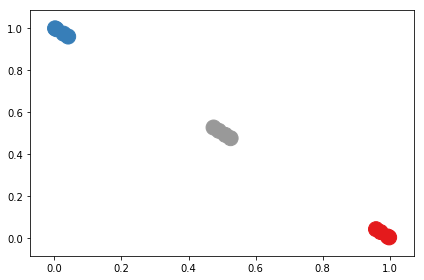

In [263]:
z = np.array(r3[-3], dtype=float)
plt.figure(tight_layout=True, facecolor='white')
plt.scatter(sdata[:, 0], 1- sdata[:, 0], c=z, cmap='Set1', s=225)
plt.show()

- Real Data In Paper

In [264]:
import csv
import numpy as np
import pandas as pd

filename = './toyexample.csv'
import pandas as pd
import numpy as np
df=pd.read_csv(filename,header=None)

In [265]:
df_new = np.array(df)
df_new_copy = np.array(df)
sum_df = np.sum(df_new, axis=1)
df_new2 =np.array([])
for i in range(df_new.shape[0]):
    df_new2 = np.append(df_new2,np.array(df_new[i,:]/sum_df[i]))
df_new2 = df_new2.reshape(120,64)
df_new2 = np.concatenate((df_new2[0:5,:], df_new2[40:45,:], df_new2[80:85,:]))

In [275]:
r2,r3= bhc(df_new2, alpha = 500, r_thres = 0.5)

In [276]:
r3

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 12, 14],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 12, 12, 14],
 [0, 1, 2, 3, 3, 5, 6, 7, 8, 9, 10, 10, 12, 12, 14],
 [0, 1, 1, 3, 3, 5, 6, 7, 8, 9, 10, 10, 12, 12, 14],
 [0, 1, 1, 3, 3, 0, 6, 7, 8, 9, 10, 10, 12, 12, 14],
 [0, 1, 1, 3, 3, 0, 6, 6, 8, 9, 10, 10, 12, 12, 14],
 [0, 1, 1, 3, 3, 0, 6, 6, 8, 8, 10, 10, 12, 12, 14],
 [0, 1, 1, 3, 3, 0, 6, 6, 8, 8, 10, 10, 12, 12, 12],
 [0, 1, 1, 1, 1, 0, 6, 6, 8, 8, 10, 10, 12, 12, 12],
 [0, 1, 1, 1, 1, 0, 6, 6, 8, 8, 6, 6, 12, 12, 12],
 [0, 1, 1, 1, 1, 0, 6, 6, 0, 0, 6, 6, 12, 12, 12],
 [0, 1, 1, 1, 1, 0, 6, 6, 0, 0, 6, 6, 6, 6, 6],
 [0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 6, 6, 6, 6, 6],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [277]:
draw_dendrogram(r2)

Node('/D28')
├── Node('/D28/D27')
│   ├── Node('/D28/D27/D25')
│   │   ├── Node('/D28/D27/D25/D21')
│   │   │   ├── Node('/D28/D27/D25/D21/D8')
│   │   │   └── Node('/D28/D27/D25/D21/D9')
│   │   └── Node('/D28/D27/D25/D19')
│   │       ├── Node('/D28/D27/D25/D19/D0')
│   │       └── Node('/D28/D27/D25/D19/D5')
│   └── Node('/D28/D27/D23')
│       ├── Node('/D28/D27/D23/D18')
│       │   ├── Node('/D28/D27/D23/D18/D1')
│       │   └── Node('/D28/D27/D23/D18/D2')
│       └── Node('/D28/D27/D23/D17')
│           ├── Node('/D28/D27/D23/D17/D3')
│           └── Node('/D28/D27/D23/D17/D4')
└── Node('/D28/D26')
    ├── Node('/D28/D26/D24')
    │   ├── Node('/D28/D26/D24/D20')
    │   │   ├── Node('/D28/D26/D24/D20/D6')
    │   │   └── Node('/D28/D26/D24/D20/D7')
    │   └── Node('/D28/D26/D24/D16')
    │       ├── Node('/D28/D26/D24/D16/D10')
    │       └── Node('/D28/D26/D24/D16/D11')
    └── Node('/D28/D26/D22')
        ├── Node('/D28/D26/D22/D15')
        │   ├── Node('/D28/D26/D22/D15/D

- Real Data Not From the Paper

In [278]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = pd.read_csv(url, names=names)
dataset=dataset.drop(['class'], axis=1)
ar_iris = np.array(dataset,dtype=None)[:, 0:3]
df_new = np.array(ar_iris)
df_new_copy = np.array(ar_iris)
sum_df = np.sum(df_new, axis=1)
df_new2 =np.array([])
for i in range(df_new.shape[0]):
    df_new2 = np.append(df_new2,np.array(df_new[i,:]/sum_df[i]))
df_new2 = df_new2.reshape(-1,3)
df_new2 = np.concatenate((df_new2[0:10,:], df_new2[50:60,:], df_new2[100:110,:]))

In [279]:
r2,r3 = bhc(df_new2, alpha = 100, r_thres = 0.5)

In [280]:
draw_dendrogram(r2)

Node('/D58')
├── Node('/D58/D57')
│   ├── Node('/D58/D57/D55')
│   │   ├── Node('/D58/D57/D55/D51')
│   │   │   ├── Node('/D58/D57/D55/D51/D43')
│   │   │   │   ├── Node('/D58/D57/D55/D51/D43/D26')
│   │   │   │   └── Node('/D58/D57/D55/D51/D43/D29')
│   │   │   └── Node('/D58/D57/D55/D51/D42')
│   │   │       ├── Node('/D58/D57/D55/D51/D42/D11')
│   │   │       └── Node('/D58/D57/D55/D51/D42/D19')
│   │   └── Node('/D58/D57/D55/D50')
│   │       ├── Node('/D58/D57/D55/D50/D41')
│   │       │   ├── Node('/D58/D57/D55/D50/D41/D15')
│   │       │   └── Node('/D58/D57/D55/D50/D41/D21')
│   │       └── Node('/D58/D57/D55/D50/D40')
│   │           ├── Node('/D58/D57/D55/D50/D40/D23')
│   │           └── Node('/D58/D57/D55/D50/D40/D24')
│   └── Node('/D58/D57/D54')
│       ├── Node('/D58/D57/D54/D48')
│       │   ├── Node('/D58/D57/D54/D48/D38')
│       │   │   ├── Node('/D58/D57/D54/D48/D38/D10')
│       │   │   └── Node('/D58/D57/D54/D48/D38/D18')
│       │   └── Node('/D58/D57/D54/D48/D37

- Traditional Clustering Method

In [2]:
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, vectorize, float64, int64
import seaborn as sns
import pandas as pd
import math 
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

In [3]:
d1 = np.random.randint(0,2, size=(7,2))
d2 = np.random.randint(9,11, size=(7,2))
d3 = np.random.randint(18,20, size=(7,2))
sdata = np.concatenate((d1,d2,d3),axis=0)

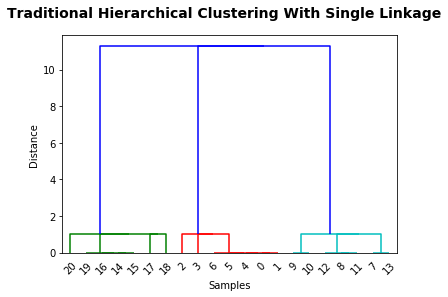

In [4]:
data = sdata
data_dist = pdist(data) # computing the distance
data_link = linkage(data_dist,method='single') # computing the linkage
dendrogram(data_link,labels=data.dtype.names)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Traditional Hierarchical Clustering With Single Linkage', fontweight='bold', fontsize=14);

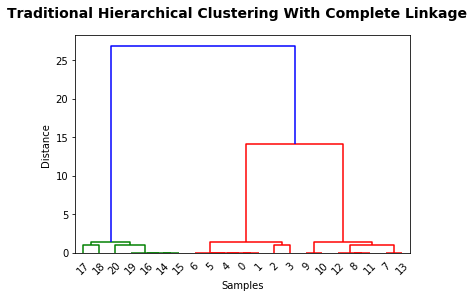

In [5]:
data = sdata
data_dist = pdist(data) # computing the distance
data_link = linkage(data_dist,method='complete') # computing the linkage
dendrogram(data_link,labels=data.dtype.names)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Traditional Hierarchical Clustering With Complete Linkage', fontweight='bold', fontsize=14);

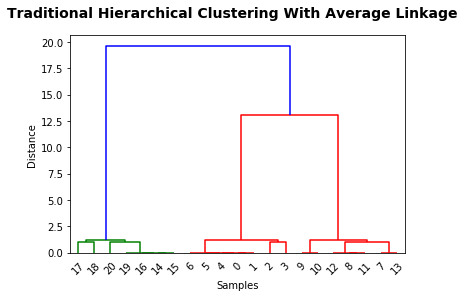

In [6]:
data = sdata
data_dist = pdist(data) # computing the distance
data_link = linkage(data_dist,method='average') # computing the linkage
dendrogram(data_link,labels=data.dtype.names)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Traditional Hierarchical Clustering With Average Linkage', fontweight='bold', fontsize=14);

In [59]:
# Naive Code
%timeit bhc(sdata, alpha = 500, r_thres = 0.5)

207 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
